Есть две выборки мутаций: одна состоит из случайных мутаций, другая - из мутаций, которые связаны с каким-то событием, например, произошли перед эпидемиями гриппа.  
Мутации делятся на стабилизирующие и дестабилизирующие:
$$N = N_+ + N_-$$
$$K = K_+ + K_-$$
$N$, $K$ - количество мутаций в выборках, $N_+$ и $K_+$, $N_-$ и $K_-$ - количество дестабилизирующих и стабилизирующих мутаций соответственно.  
  
Надо найти enrichment = $\frac{K_-/K}{N_-/N}$ и p-value.

Классификатор присваивает классы со следующими вероятностями:

|Вероятность|На самом деле|Предсказана как|
|-----------|-------------------|-------------------|
| $p_+$     | дестабилизирующая | дестабилизирующая |
| $1 - p_+$ | дестабилизирующая | стабилизирующая   |
| $p_-$     | стабилизирующая   | стабилизирующая   |
| $1-p_-$   | стабилизирующая   | дестабилизирующая |

$$N = N_{pr+} + N_{pr-}$$
$$K = K_{pr+} + K_{pr-}$$
$N_{pr+}$ и $K_{pr+}$, $N_{pr-}$ и $K_{pr-}$ - количество  мутаций, предсказанных как дестабилизирующие и стабилизирующие соответственно.

Для выборки из случайных мутаций:
$$\begin{cases} N_{pr-} = N_- p_- + (N - N_-)(1 - p_+) \\ N_{pr+} = N - N_{p_-} \end{cases}$$
$$\begin{cases} N_- = \frac{N_{pr-} - N(1-p_+)}{p_- + p_+ - 1}\\ N_{+} = \frac{Np_- - N_{pr-}}{p_- + p_+ - 1} \end{cases}$$

Аналогично для второй выборки.
$$enrichment = \frac{K_-/K}{N_-/N} = \frac{(K_{pr}-K(1-p_+))N}{(N_{pr}-N(1-p_+))K}$$

In [173]:
def limit(x, N):
    return max(min(x, N), 0)

def actual_N_minus(N_pr_minus, N, p_plus, p_minus):
    return limit(int((N_pr_minus - N * (1 - p_plus)) / (p_minus + p_plus - 1)), N)

def actual_N_plus(N_pr_minus, N, p_plus, p_minus):
    return limit(int((N * p_minus - N_pr_minus) / (p_minus + p_plus - 1)), N)

### Классификатор

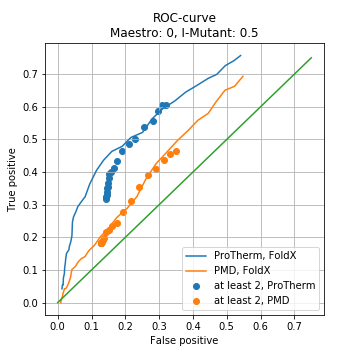

In [1]:
from IPython.display import Image
Image(filename = "2_programs_ROC.png")

Эти ROC-кривые построены следующим образом: для I-Mutant и Maestro выбраны определенные пороги, у FoldX порог меняется. Мутация определяется как стабилизирующая, если хотя бы две программы предсказывают мутацию как стабилизирующую. Точность получается не лучше, чем у FoldX.  
В итоге я выбрала точку с $True\ positive = 0.44$, $False\ positive = 0.31$ (в PMD).

|Программа|Порог|
|-----------|-------------------|
|FoldX     |0.6|
|Maestro|0|
|I-Mutant|0.5|

In [101]:
p_plus = 0.69
p_minus = 0.44

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings(action='ignore')

In [14]:
pmd = pd.read_csv('pmd_without_pth_2233.main.pph.ddg.tsv', sep='\t').drop(columns='Unnamed: 0', axis = 1)
pth = pd.read_csv('pth_converted_signs_2182.main.pph.ddg.tsv', sep='\t').drop(columns='Unnamed: 0', axis = 1)
pth_sign = pth[['PDB_id', 'sign', 'FX_ddG', 'IM_ddG', 'M_ddG']]
pmd['sign'] = pmd['ddG'].map({'-': '-', '+': '+', '=': '+'})
pth_sign['sign'] = pth_sign['sign'].map({'-': '-', '+': '+', '0': '+'})
pmd_sign = pmd[['PDB_id', 'sign', 'FX_ddG', 'IM_ddG', 'M_ddG']]

,# ID,pos,aa1,aa2,ddG,shift,prediction,PDB_id,PDB_pos,PDB_ch,ident,NormASA,SecStr,MapReg,dVol,dProp,B-fact,FX_ddG,IM_ddG,M_ddG,M_conf
0,PT1_ECOLI,189,H,E,+,0,probably damaging,2xdf,189,B,1.0,0.476,H,A,-15,0.87,0.89,0.359588,0.45,-0.071356,0.866660
1,PT1_ECOLI,189,H,A,-,0,probably damaging,2xdf,189,B,1.0,0.476,H,A,-65,0.17,0.89,0.188145,0.29,0.272067,0.865162
2,LEU3_ECOLI,200,Q,E,-,0,probably damaging,1cm7,200,B,1.0,0.320,H,A,-6,0.40,-0.60,0.603746,0.47,-0.162243,0.940071
3,ACKA_METTE,60,H,A,=,0,probably damaging,1tuy,60,A,1.0,0.076,H,A,-65,0.17,0.38,0.856264,1.20,0.211844,0.931539
4,ACKA_METTE,90,H,A,=,0,probably damaging,1tuy,90,A,1.0,0.006,E,B,-65,0.17,-0.16,0.462928,1.57,0.214069,0.926022


In [15]:
programs = ['FX_ddG', 'IM_ddG', 'M_ddG']
thresholds = {'FX_ddG': 0.6, 'IM_ddG': 0.5, 'M_ddG': 0}

In [16]:
def convert(x, t):
    if x < t:
        return 1
    else:
        return 0

def convert_to_sign(row, programs=['FX_ddG', 'IM_ddG', 'M_ddG'],
                    thresholds={'FX_ddG': 0.6, 'IM_ddG': 0.5, 'M_ddG': 0}):
    # 1 - '-', 0 - '+'
    res = [convert(row[p], thresholds[p]) for p in programs]
    if sum(res) >= 2:
        return '-'
    else:
        return '+'

In [17]:
pth_sign['prediction'] = pth_sign.apply(convert_to_sign, axis=1)
pmd_sign['prediction'] = pmd_sign.apply(convert_to_sign, axis=1)

In [18]:
pth_sign.head()

,PDB_id,sign,FX_ddG,IM_ddG,M_ddG,prediction
0,2bpp,+,2.709300,1.28,1.572728,+
1,2bpp,+,1.618320,1.43,1.001211,+
2,2bpp,+,1.489130,1.38,1.361416,+
3,4z0u,+,0.096669,0.21,-0.205215,-
4,4z0u,+,0.226252,0.44,0.238653,-


In [19]:
pmd_sign.head()

,PDB_id,sign,FX_ddG,IM_ddG,M_ddG,prediction
0,2xdf,+,0.359588,0.45,-0.071356,-
1,2xdf,-,0.188145,0.29,0.272067,-
2,1cm7,-,0.603746,0.47,-0.162243,-
3,1tuy,+,0.856264,1.20,0.211844,+
4,1tuy,+,0.462928,1.57,0.214069,+


In [76]:
pth_cont = pd.crosstab(index=pth_sign["sign"], 
                           columns=pth_sign["prediction"], margins=True)
pth_cont

prediction,+,-,All
sign,,,
+,1353,570,1923
-,107,152,259
All,1460,722,2182


In [77]:
pmd_cont = pd.crosstab(index=pmd_sign["sign"], 
                           columns=pmd_sign["prediction"], margins=True)
pmd_cont

prediction,+,-,All
sign,,,
+,1308,599,1907
-,184,142,326
All,1492,741,2233


#### Случайные мутации

In [81]:
random = pd.read_csv('random.tsv', sep='\t').drop(columns=['M_conf'], axis=1)
random = random[random['IM_ddG'] != '-']
for col in ['FX_ddG', 'IM_ddG', 'M_ddG']:
    random[col] = pd.to_numeric(random[col], errors='raise')
    
random = random[(random['FX_ddG'] < 20) & (random['FX_ddG'] > -20)]
random['prediction'] = random.apply(convert_to_sign, axis=1)
random.head()

,PDB,CHAIN,POS,AA1,AA2,Error,FX_ddG,IM_ddG,M_ddG,prediction
0,1a0e,D,1,A,C,No,0.166930,0.69,-0.010546,-
1,1a0e,D,1,A,E,No,0.523503,0.39,-0.155882,-
2,1a0e,D,1,A,G,No,-0.148323,0.83,0.101193,+
3,1a0e,D,1,A,Q,No,0.121549,0.42,-0.153705,-
4,1a0e,D,1,A,R,No,-0.215640,0.21,-0.384062,-


### Сравнение определенных мутаций в одном белке с фоновым уровнем

Составляем выборки из мутаций в одном белке и смотрим, насколько количество стабилизирующих отличается от случайного количества. Белки с максимальным количеством известных стабилизирующих мутаций в обеих базах данных:

In [69]:
all_sign = pd.concat([pmd_sign, pth_sign])

In [72]:
most_freq = [i for (i, j) in all_sign[all_sign['sign']=='-'].PDB_id.value_counts()[0:10].items()]
signs_most_freq = []
for p in most_freq:
    signs_most_freq.append(all_sign[all_sign['PDB_id'] == p].sign.value_counts().to_frame(p))
signs_most_freq = pd.concat(signs_most_freq, axis=1)
signs_most_freq

,1hp7,4z0u,3lzm,1c46,2kdc,5ccc,1wq5,4pnj,9lyz,3whi
+,28,49,310,122,NaN,112,98,101,77,12
-,51,29,16,14,14.0,13,13,10,9,9


### Сравнение двух выборок

In [82]:
pd.crosstab(index=all_sign["sign"], columns=all_sign["prediction"], margins=True)

prediction,+,-,All
sign,,,
+,2661,1169,3830
-,291,294,585
All,2952,1463,4415


In [219]:
def cont_table(df, N, proportion):
    n_1 = int(proportion * N)
    n_2 = int((1 - proportion) * N)
    
    dataset1 = df[df['sign'] == '-'].sample(n=n_1, replace=True)
    dataset1 = pd.concat([dataset1, df[df['sign'] == '+'].sample(n=(N - n_1), replace=True)])
    dataset2 = df[df['sign'] == '-'].sample(n=n_2, replace=True)
    dataset2 = pd.concat([dataset2, df[df['sign'] == '+'].sample(n=(N-n_2), replace=True)])
            
    N_pr_minus_1 = len(dataset1[dataset1['prediction'] == '-'])
    N_pr_plus_1 = len(dataset1[dataset1['prediction'] == '+'])
    N_pr_minus_2 = len(dataset2[dataset2['prediction'] == '-'])
    N_pr_plus_2 = len(dataset2[dataset2['prediction'] == '+'])
            
    N_minus_1 = len(dataset1[dataset1['sign'] == '-'])
    N_plus_1 = len(dataset1[dataset1['sign'] == '+'])
    N_minus_2 = len(dataset2[dataset2['sign'] == '-'])
    N_plus_2 = len(dataset2[dataset2['sign'] == '+'])
    actual_contingency_table = pd.DataFrame(np.array([[N_minus_1, N_plus_1], [N_minus_2, N_plus_2]]),
                                             index=['dataset1', 'dataset2'], columns=['-', '+'])
    print('actual_enrichment:', round(N_minus_2/N_minus_1, 2))
    display(actual_contingency_table)
    
    N_minus_1 = actual_N_minus(N_pr_minus_1, len(dataset1), p_plus, p_minus)
    N_plus_1 = actual_N_plus(N_pr_minus_1, len(dataset1), p_plus, p_minus)
    N_minus_2 = actual_N_minus(N_pr_minus_2, len(dataset2), p_plus, p_minus)
    N_plus_2 = actual_N_plus(N_pr_minus_2, len(dataset2), p_plus, p_minus)
    contingency_table = pd.DataFrame(np.array([[N_minus_1, N_plus_1], [N_minus_2, N_plus_2]]),
                                    index=['dataset1', 'dataset2'], columns=['-', '+'])

    print('enrichment:', round(N_minus_2/N_minus_1, 2))
    display(contingency_table)
            

In [221]:
for i in range(10):
    print(i)
    cont_table(all_sign, 600, 0.7)

0
actual_enrichment: 0.43


,-,+
dataset1,420,180
dataset2,180,420


enrichment: 0.91


,-,+
dataset1,538,61
dataset2,492,107


1
actual_enrichment: 0.43


,-,+
dataset1,420,180
dataset2,180,420


enrichment: 0.29


,-,+
dataset1,600,0
dataset2,176,423


2
actual_enrichment: 0.43


,-,+
dataset1,420,180
dataset2,180,420


enrichment: 0.66


,-,+
dataset1,538,61
dataset2,353,246


3
actual_enrichment: 0.43


,-,+
dataset1,420,180
dataset2,180,420


enrichment: 0.41


,-,+
dataset1,500,100
dataset2,207,392


4
actual_enrichment: 0.43


,-,+
dataset1,420,180
dataset2,180,420


enrichment: 0.81


,-,+
dataset1,553,46
dataset2,446,153


5
actual_enrichment: 0.43


,-,+
dataset1,420,180
dataset2,180,420


enrichment: 0.41


,-,+
dataset1,600,0
dataset2,246,353


6
actual_enrichment: 0.43


,-,+
dataset1,420,180
dataset2,180,420


enrichment: 0.29


,-,+
dataset1,600,0
dataset2,176,423


7
actual_enrichment: 0.43


,-,+
dataset1,420,180
dataset2,180,420


enrichment: 0.31


,-,+
dataset1,600,0
dataset2,184,415


8
actual_enrichment: 0.43


,-,+
dataset1,420,180
dataset2,180,420


enrichment: 0.58


,-,+
dataset1,553,46
dataset2,323,276


9
actual_enrichment: 0.43


,-,+
dataset1,420,180
dataset2,180,420


enrichment: 0.34


,-,+
dataset1,600,0
dataset2,207,392
